In [1]:
import numpy as np
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import seaborn as sns
import tensorflow as tf
%matplotlib inline


In [2]:
def plotchr(image,label,i):
    sns.set_context("talk")
    plt.subplot(1,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("%d" % np.argmax(label))
    plt.imshow(image,cmap=plt.cm.gray_r)

In [174]:
np.random.seed(20170730)
tf.set_random_seed(20170730)

# 実験データの生成関数

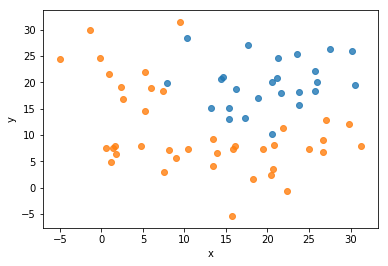

In [175]:
def generate_datablock(n, mu, var, label):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = DataFrame(data, columns =['x','y'])
    df['l' ] = label
    return df

df0 = generate_datablock(15, [7,7], 22, 0)
df1 = generate_datablock(15, [22,7], 22, 0)
df2 = generate_datablock(10, [7,22], 22, 0)
df3 = generate_datablock(25, [20,20], 22, 1)

df = pd.concat([df0,df1,df2,df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

sns.regplot(x="x", y="y", data=df[df['l']==1],fit_reg=False)
sns.regplot(x="x", y="y", data=df[df['l']==0],fit_reg=False)

plt.show()

# データの取り出し

In [176]:
train_x = train_set[['x','y']].as_matrix()
train_t = train_set[['l']].as_matrix()

# モデル定義

In [177]:
num_units = 2
mult = train_x.flatten().mean()   # x,yを区別しない平均値

In [178]:
x = tf.placeholder(tf.float32,[None,2])

w1 = tf.Variable(tf.truncated_normal([2, num_units]))   # 0 を平均として分散1の正規分布乱数で初期化
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.tanh(tf.matmul(x,w1) + b1*mult)

w0 = tf.Variable(tf.zeros([num_units,1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1,w0) + b0*mult)

# 誤差関数の定義

In [179]:
t = tf.placeholder(tf.float32, [None,1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
#train_step = tf.train.AdamOptimizer().minimize(loss)
train_step = tf.train.GradientDescentOptimizer(0.003).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 学習セッション

In [180]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [181]:
times = 0
for _ in range(1000):
    times += 1
    sess.run(train_step, feed_dict = {x:train_x, t:train_t})
    if times  % 100 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict = {x:train_x, t:train_t})
        print("Step: {0:d}, Loss: {1:f}, Accuracy: {2:f}".format(times, loss_val, acc_val))

Step: 100, Loss: 230.004089, Accuracy: 0.384615
Step: 200, Loss: 114.925804, Accuracy: 0.661538
Step: 300, Loss: 95.798973, Accuracy: 0.538462
Step: 400, Loss: 14.774084, Accuracy: 0.953846
Step: 500, Loss: 14.236907, Accuracy: 0.953846
Step: 600, Loss: 9.455277, Accuracy: 0.953846
Step: 700, Loss: 9.408392, Accuracy: 0.953846
Step: 800, Loss: 9.377880, Accuracy: 0.953846
Step: 900, Loss: 11.361700, Accuracy: 0.969231
Step: 1000, Loss: 10.376982, Accuracy: 0.969231


# 検証

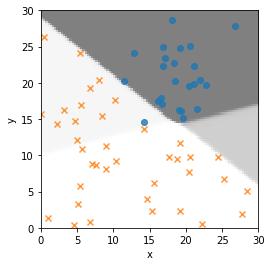

In [171]:
#train_set1 = train_set[train_set['l']==1]
#train_set1 = train_set[train_set['l']==0]

sns.regplot(x="x", y="y", data=df[df['l']==1],fit_reg=False, marker="o")
sns.regplot(x="x", y="y", data=df[df['l']==0],fit_reg=False,marker="x")

locations = []
for y1 in np.linspace(0,30,100):
    for x1 in np.linspace(0,30,100):
        locations.append([x1,y1])
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
plt.imshow(p_vals, origin='lower', extent=(0,30,0,30), cmap=plt.cm.gray_r, alpha = 0.5)

この結果は、左上から右下にかけての境界面がほぼ支配的である。（15，15）付近の1点を除けば、この境界面の上下という判断だけで青と赤はクラスタ分けできる。唯一この1点だけが高い確率で誤判定となる。

# パラメータを少しだけ変えた結果

In [172]:
train_step = tf.train.GradientDescentOptimizer(0.0033).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
times = 0
for _ in range(1000):
    times += 1
    sess.run(train_step, feed_dict = {x:train_x, t:train_t})
    if times  % 100 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict = {x:train_x, t:train_t})
        print("Step: {0:d}, Loss: {1:f}, Accuracy: {2:f}".format(times, loss_val, acc_val))

Step: 100, Loss: 61.775669, Accuracy: 0.769231
Step: 200, Loss: 199.961624, Accuracy: 0.615385
Step: 300, Loss: 24.115753, Accuracy: 0.969231
Step: 400, Loss: 0.455952, Accuracy: 1.000000
Step: 500, Loss: 0.403756, Accuracy: 1.000000
Step: 600, Loss: 0.363350, Accuracy: 1.000000
Step: 700, Loss: 0.331120, Accuracy: 1.000000
Step: 800, Loss: 0.304821, Accuracy: 1.000000
Step: 900, Loss: 0.282966, Accuracy: 1.000000
Step: 1000, Loss: 0.264523, Accuracy: 1.000000


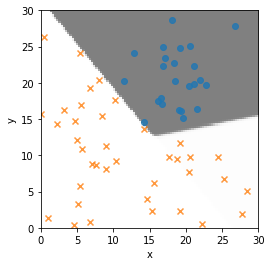

In [173]:
#train_set1 = train_set[train_set['l']==1]
#train_set1 = train_set[train_set['l']==0]

sns.regplot(x="x", y="y", data=df[df['l']==1],fit_reg=False, marker="o")
sns.regplot(x="x", y="y", data=df[df['l']==0],fit_reg=False,marker="x")

locations = []
for y1 in np.linspace(0,30,100):
    for x1 in np.linspace(0,30,100):
        locations.append([x1,y1])
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
plt.imshow(p_vals, origin='lower', extent=(0,30,0,30), cmap=plt.cm.gray_r, alpha = 0.5)

見てわかるように、この学習結果によって、すべての事例が高い確率で正答できる。
隠れ層の２つのニューロンがそれぞれ２つの判定面の識別を担い、出力層の唯一のニューロンがその論理和を計算するように構成されたと考えてよかろう。